# Imports and installs

In [1]:
# #Only Rafa
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap
import itertools

# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [3]:
def get_data(league1, wall=False):
    '''
    This function is getting the CSVs in the raw_data folder per country.
    We can have only one country, we just need to pass the name of the country in lower case.
    Or we can have all the countries inside the folder, we just need to pass the param wall=True.
    '''
    
    data = pd.DataFrame()
    if wall:
        leagues = listdir(f'../raw_data/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'../raw_data/{league}')
            for file in files:
                df = pd.read_csv((f'../raw_data/{league}/'+file), encoding='windows-1252')
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])

        return data
    
    else:
        files = [file for file in listdir(f'../raw_data/{league1}')]

        for file in files:
            df = pd.read_csv(f'./../raw_data/{league1}/'+file)
            data = pd.concat([data, df])

        return data

##### Initiating Data Frame

In [4]:
# Customise based on your path and folder organisation
print(os.listdir('../raw_data/All4'))

['spain_2019_2020_1.csv', 'italy_2020_2021_2.csv', 'italy_2021_2022_1.csv', 'italy_2021_2022_2.csv', 'spain_2020_2021_1.csv', 'spain_2020_2021_2.csv', 'scotland_2020_2021_2.csv', 'Turkey_2021_2022_1.csv', 'scotland_2020_2021_3.csv', 'scotland_2019_2020_1.csv', 'france_2021_2022_1.csv', 'germany_2021_2022_1.csv', 'belgium_2020_2021_1.csv', 'scotland_2021_2022_4.csv', 'scotland_2020_2021_1.csv', 'france_2019_2020_1.csv', 'germany_2021_2022_2.csv', 'germany_2019_2020_1.csv', 'england_2020_2021_3.csv', 'scotland_2019_2020_2.csv', 'italy_2019_2020_1.csv', 'scotland_2020_2021_4.csv', 'portugal_2021_2022_1.csv', 'france_2020_2021_2.csv', 'scotland_2021_2022_3.csv', 'england_2021_2022_3.csv', 'portugal_2019_2020_1.csv', 'Greece_2021_2022_1.csv', 'england_2020_2021_4.csv', 'england_2021_2022_4.csv', 'france_2020_2021_1.csv', 'germany_2020_2021_1.csv', 'scotland_2019_2020_4.csv', 'spain_2019_20220_2.csv', 'germany_2019_2020_2.csv', 'england_2019_2020_4.csv', 'scotland_2021_2022_1.csv', 'england_

In [5]:
# Concatenate all the CSVs
files = [file for file in os.listdir('../raw_data/All4') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/All4/' + file)
    df['country']=str(file)[0:2]
    df['country_division']=int(str(file)[-5:-4])
    data = pd.concat([data, df])

# Features Engineering

In [6]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 10]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    

    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3"], data["3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 avg closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 avg closing']])
    data["avg_1.0_to_1.5"], data["avg_1.5_to_2.0"], data["avg_2.0_to_3"], data["avg_3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 avg closing', inplace=True)
    
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    #data.drop(columns='country_division', inplace=True)
    
    return data

##### Running the function and creating the cleaned and features dataset data

In [7]:
#Running the function and creating the dataset data
data = feature_engineering(data, b=5)

In [8]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['season_20_21'] = (data_date_2>='2020-09-01') & (data_date_2<'2021-09-01')
data['season_training2'] = (data_date_2<'2020-09-01')

#Hours
data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Hours feature
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})
data['hour_number_2'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})
data['hour_number_2_ratio'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})/4
data['hour_number_ratio'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

#OHE before after 4pm
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

#OHE Hours groups (4 groups)  
ohe.fit(data[['hour_number_2']])
bins_encoded = ohe.transform(data[['hour_number_2']])
data["hour_group_1"], data["hour_group_2"], data["hour_group_3"], data["hour_group_4"] = bins_encoded.T
    
#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

#Months
data['month_number']=data['month']
data['month_number_ratio']=data['month']/12
data['year_number'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4
data['year_number_month_ratio'] = data['year_number']+data['month_number_ratio']
data['year_number_month_decimal'] = data['year_number']+data['month_number']/10

#OHE years
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['year_number']])
bins_encoded = ohe.transform(data[['year_number']])
data["year_1"], data["year_2"], data["year_3"], data["year_4"] = bins_encoded.T

#OHE months
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['month_number']])
bins_encoded = ohe.transform(data[['month_number']])
data["month_1"], data["month_2"], data["month_3"], data["month_4"], data["month_5"], data["month_6"], data["month_7"], data["month_8"], data["month_9"], data["month_10"], data["month_11"], data["month_12"] = bins_encoded.T

data.rename(columns = {'PC<2.5':'PC_under_2.5'}, inplace = True)

In [9]:
# Min_max_scaler
scaler = RobustScaler().fit(data[['PC_under_2.5']]) 
data['PC_under_2.5_scaled'] = scaler.transform(data[['PC_under_2.5']]) # Use scaler to transform data

# Defining the Model functions (XGB models for under 2.5)

### Function testing_model

In [10]:
def testing_models_regressor(iterations,test_size_0,train_size_0):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        _ignore1, X_test_model, _ignore2, y_test_model = train_test_split(X_test_0, y_test_0, test_size=test_size_0)
        X_train_model, _ignore3, y_train_model, _ignore4 = train_test_split(X_train_0, y_train_0, test_size=(1-train_size_0)) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_model,y_train_model) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test_model)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test_model)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_under_2.5_pinacle_closing'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
         
        i=i+1
        
    return results_xgb_false, results_xgb_true, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4

In [115]:
def testing_models_regressor2(m,iterations,test_size_0,train_size_0):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        _ignore1, X_test_model, _ignore2, y_test_model = train_test_split(X_test_0, y_test_0, test_size=test_size_0)
        X_train_model, _ignore3, y_train_model, _ignore4 = train_test_split(X_train_0, y_train_0, test_size=(1-train_size_0)) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test_model)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test_model)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         xgb_results_False_n = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_under_2.5_pinacle_closing'].count()
#         xgb_results_True_n = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_under_2.5_pinacle_closing'].count()
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_under_2.5_pinacle_closing'].mean()
        
        results_xgb_False.append(xgb_results_False)
        results_xgb_True.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
         
        i=i+1
        
    return results_xgb_False, results_xgb_True, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4

In [116]:
def checking_model_regressor_results(n=10, b=20, test_size_0=0.8, train_size_0=0.999, m=False):
    
    # Empty_lists
    results_xgb_true=[] 
    results_xgb_false=[]
    results_xgb_1=[]
    results_xgb_2=[]
    results_xgb_3=[]
    results_xgb_4=[]
    
    
    
    if m != False:
        print('Iniciando modelo pré treinado')
        results_xgb_false, results_xgb_true, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4 = testing_models_regressor2(m,n,test_size_0,train_size_0)

    else:
        print('Iniciando modelo não treinado')
        # Run the model regressor X times
        results_xgb_false, results_xgb_true, results_xgb_1, results_xgb_2, results_xgb_3, results_xgb_4 = testing_models_regressor(n,test_size_0,train_size_0)
    
    # Results
    median_results_bad_bets = np.median(np.array(results_xgb_false))
    median_results_good_bets = np.median(np.array(results_xgb_true))
    delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))
    delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))
    #print(delta, delta_extremes)
    
    #Plotting the results of the XGB
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    sns.histplot(results_xgb_true,kde=True,bins=b,color='green',ax=ax[0], label='Bad')
    sns.histplot(results_xgb_false,kde=True,bins=b,color='red',ax=ax[0], label='Good')
    
    sns.histplot(results_xgb_1,kde=True,bins=b,color='red',ax=ax[1], label = 'Ex Bad')
    sns.histplot(results_xgb_2,kde=True,bins=b,color='orange',ax=ax[1], label='Bad')
    sns.histplot(results_xgb_3,kde=True,bins=b,color='grey',ax=ax[1], label='Good')
    sns.histplot(results_xgb_4,kde=True,bins=b,color='green',ax=ax[1], label='Ex Good')
    plt.legend()


    return delta, delta_extremes

# Running the Models

## Define the features for the Models

In [55]:
## Declaring TEST and TRAIN dates
data['test_dates'] = data_date_2>='2021-09-01'
data['train_dates'] = (data_date_2>='2019-09-01') & (data_date_2<'2021-09-01')

### Reset the indices

In [56]:
#data.reset_index(inplace=True, drop=True)

# Regressor Model variables
X_train_0 = data[data['train_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_p_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_10']]#,'year_number_ratio','month_number_ratio']]
X_test_0 = data[data['test_dates']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_p_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'1.0_to_1.5','1.5_to_2.0','2.0_to_3','3_to_10']]#,'year_number_ratio','month_number_ratio']]
y_train_0 = data[data['train_dates']==True]['payout_under_2.5_pinacle_closing']-1
y_test_0 = data[data['test_dates']==True]['payout_under_2.5_pinacle_closing']-1

# Classifier Model variables
y_test_0_classifier = data[data['test_dates']==True]['payout_under_2.5_pinacle_closing']!=0
y_train_0_classifier = data[data['train_dates']==True]['payout_under_2.5_pinacle_closing']!=0

## Run Regression model


Iniciando modelo não treinado


(0.06799375556322058, 0.12754207797560874)

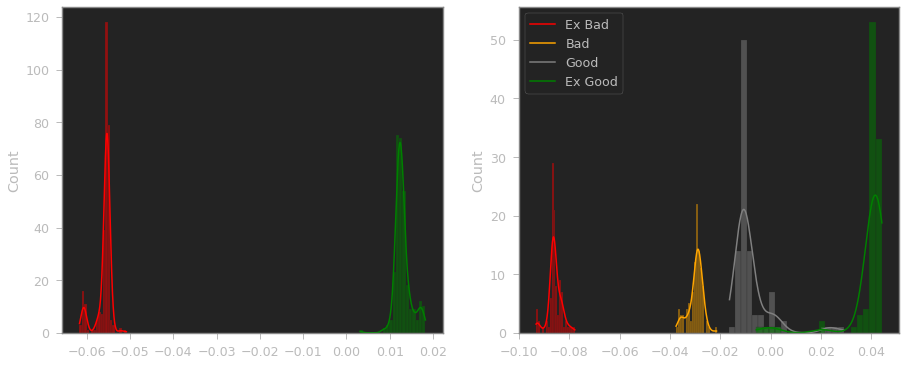

In [89]:
## RUN THE WHOLE CELL #

# We need to run this to null the lists
results_xgb_True=[] 
results_xgb_False=[]
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]
    
#We need to run this to reinitate the test_size

# We need to run the function -> first: # of tests, second: test size (cannot be 1!), third: train size (cannot be 1!)
checking_model_regressor_results(100)

## Checking the SHAP values for the Regression model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


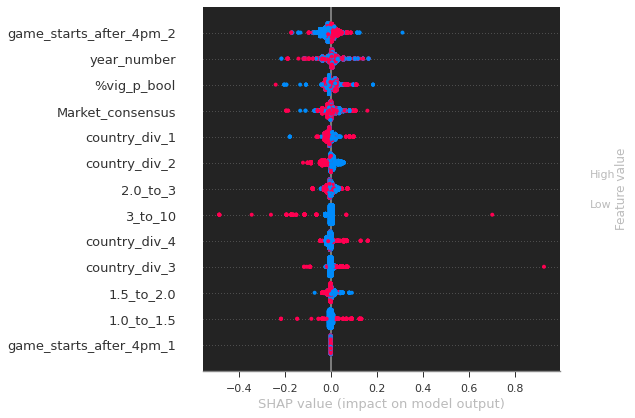

In [15]:
my_model = xgb.XGBRegressor()
my_model.fit(X_train_0,y_train_0)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test_0)
shap.summary_plot(shap_values, X_test_0)

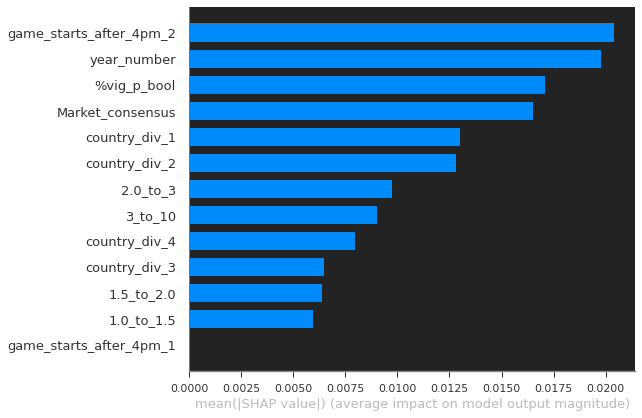

In [16]:
shap.summary_plot(shap_values, X_test_0, plot_type="bar", color_bar_label='white')

## Hyperparams

### Grid Search 

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
model = xgb.XGBRegressor()

parameters = {
    'booster': ['gbtree'],
    'max_depth': [2, 4, 6],
    'subsample': [0.5, 1],
    'n_estimators': range(60, 500, 50),
    'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.01],
    'gamma': [0, 1]
}

fit_params = {"early_stopping_rounds":[20, 40, 60, 80],
              "eval_metric": 'r2_score'
              "eval_set" : [[X_test_0, y_test_0]]
             }

grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=1
)

# Fit data to Grid Search
grid_search.fit(X_train_0,y_train_0);
grid_search.best_estimator_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [ ]:
print(grid_search.best_estimator_)

### Random Search

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [121]:
# Instanciate model
model = xgb.XGBRegressor()

parameters = {
    'booster': ['gbtree'],
    'max_depth': [2, 4, 6],
    'subsample': [0.5, 1],
    'n_estimators': range(60, 500, 50),
    'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.01],
    'gamma': [0, 1]
}

# fit_params = {"early_stopping_rounds":[20, 40, 60, 80],
#               "eval_metric": 'r2_score'
#               "eval_set": [[X_test_0, y_test_0]]
#              }

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameters,
    n_iter = 100,
    n_jobs = -1,
    cv = 5,
    verbose=1
)

random_search.fit(X_train_0,y_train_0);
random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
XGBRegressor
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_dep

In [24]:
print(random_search.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=410, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)


In [25]:
print(random_search.best_score_)

-0.000646317680564934


Iniciando modelo pré treinado


(-0.003457227711800112, nan)

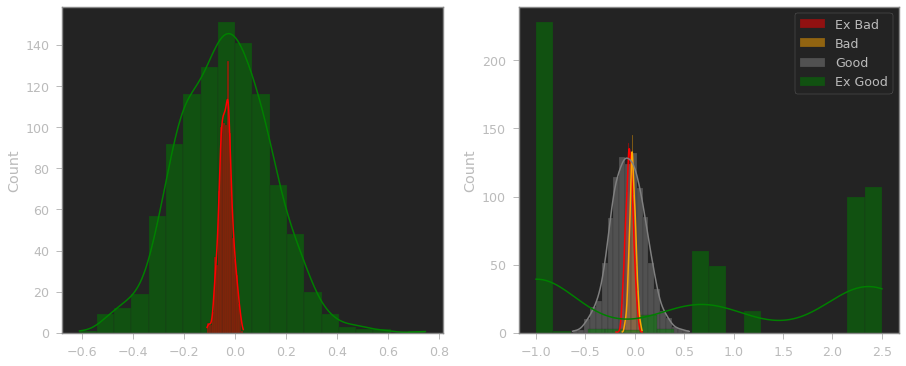

In [120]:

results_xgb_True=[] 
results_xgb_False=[]
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]

checking_model_regressor_results(n=1000, test_size_0=0.2, train_size_0=0.999, m=random_search.best_estimator_)


Iniciando modelo não treinado


(0.06755470561425513, 0.1272294725607947)

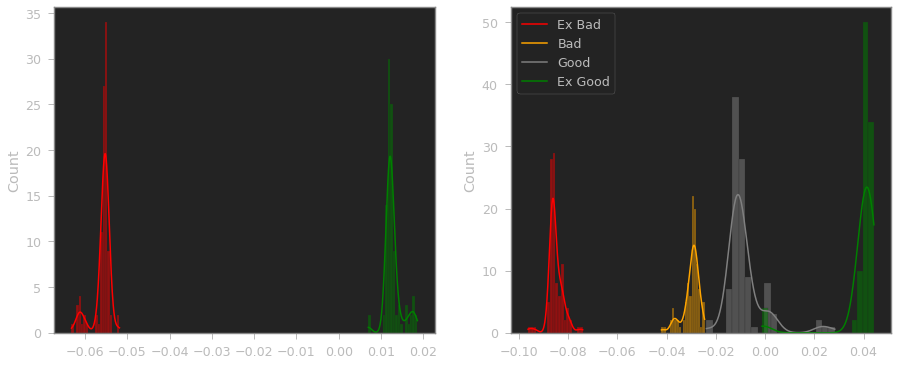

In [65]:
results_xgb_true=[] 
results_xgb_false=[]
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]

checking_model_regressor_results(n=100, test_size_0=0.999, train_size_0=0.999)